In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

In [ ]:
# 1. Load Data
df = pd.read_csv('chicago_airbnb_cleaned.csv')

# Define your strategic feature list
optimized_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
    'host_is_superhost', 'host_listings_count', 'minimum_nights',
    'instant_bookable', 'availability_365', 'number_of_reviews',
    'reviews_per_month', 'review_scores_rating',
    'room_type_Private room', 'room_type_Shared room', 'room_type_Hotel room',
    'property_type_clean_Entire home', 'property_type_clean_Entire rental unit',
    'Amenity_PCA_1', 'Amenity_PCA_2', 'Amenity_PCA_3', 'Amenity_PCA_4', 'Amenity_PCA_5'
]

# Ensure the selected features are strictly numeric
# This maps any remaining 't'/'f' to 1/0 just in case
X = df[optimized_features].copy()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].map({'t': 1, 'f': 0, 1: 1, 0: 0}).fillna(0)

# Final numeric check
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

In [ ]:
# 2. Feature Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

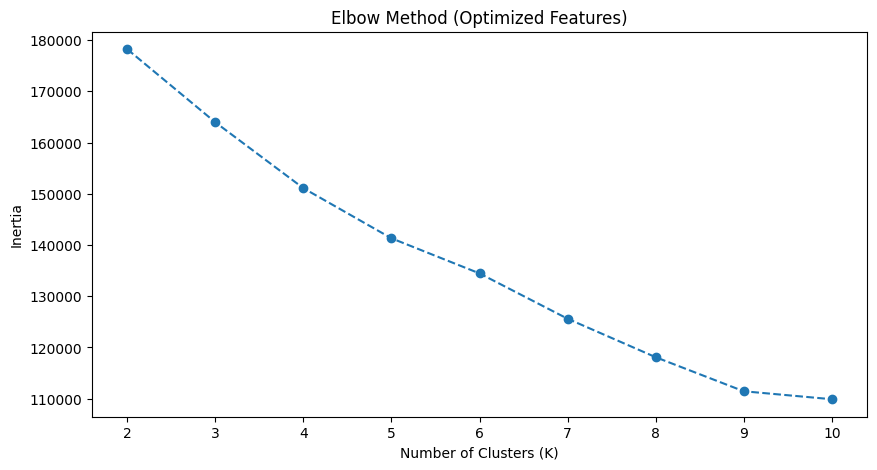

In [ ]:
# 3. Elbow Method
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='#1f77b4')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Optimized Features)')
plt.show()

In [ ]:
# 4. Final K-Means (Using K=5 as seen in your previous plot)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


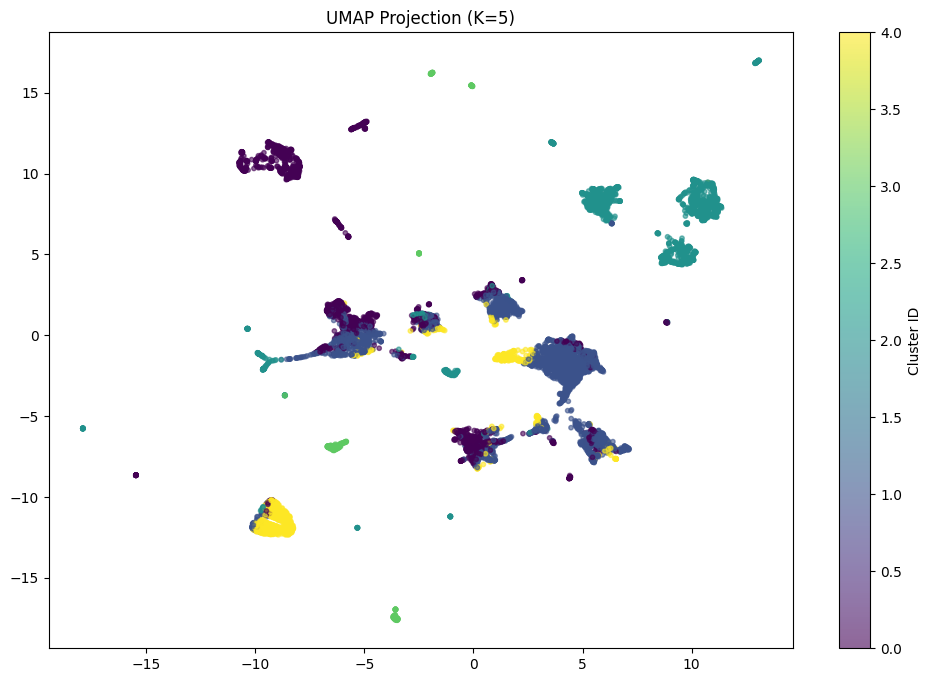

In [ ]:
# 5. UMAP for Visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Cluster_ID'], cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster ID')
plt.title(f'UMAP Projection (K={optimal_k})')
plt.show()

In [ ]:
# Calculate the average values for key business metrics per cluster
cluster_profile = df.groupby('Cluster_ID')[['price', 'accommodates', 'review_scores_rating', 'Amenity_PCA_1', 'Amenity_PCA_2']].mean()

# Sort by price to see the market hierarchy
print(cluster_profile.sort_values(by='price', ascending=False))

                   price  accommodates  review_scores_rating  Amenity_PCA_1  \
Cluster_ID                                                                    
3           11378.912409      3.532847              4.787810      -1.251853   
4             494.539022     10.421436              4.832778       0.983285   
0             193.840654      3.261682              4.719776      -1.111166   
1             191.606408      5.054674              4.844353       0.918405   
2              91.995220      2.010621              4.720685      -0.716116   

            Amenity_PCA_2  
Cluster_ID                 
3                0.114965  
4               -0.139310  
0                0.488286  
1               -0.001177  
2               -0.498433  


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Calculate Evaluation Metrics
print("--- Clustering Quantitative Evaluation ---")

# Silhouette Score (Closer to 1 is better)
sil_score = silhouette_score(X_scaled, df['Cluster_ID'])
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index (Lower is better)
dbi_score = davies_bouldin_score(X_scaled, df['Cluster_ID'])
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

# Calinski-Harabasz Index (Higher is better)
ch_score = calinski_harabasz_score(X_scaled, df['Cluster_ID'])
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

--- Clustering Quantitative Evaluation ---
Silhouette Score: 0.1295
Davies-Bouldin Index: 2.0651
Calinski-Harabasz Index: 886.0628


In [ ]:
# Grouping by Cluster_ID to see the business DNA of each segment
profile = df.groupby('Cluster_ID')[['price', 'accommodates', 'review_scores_rating', 'Amenity_PCA_1', 'Amenity_PCA_2']].mean()

# Formatting for better readability
print("📊 Cluster Business Profiles (Average Values):")
print(profile.sort_values(by='price', ascending=False).round(2))

📊 Cluster Business Profiles (Average Values):
               price  accommodates  review_scores_rating  Amenity_PCA_1  \
Cluster_ID                                                                
3           11378.91          3.53                  4.79          -1.25   
4             494.54         10.42                  4.83           0.98   
0             193.84          3.26                  4.72          -1.11   
1             191.61          5.05                  4.84           0.92   
2              92.00          2.01                  4.72          -0.72   

            Amenity_PCA_2  
Cluster_ID                 
3                    0.11  
4                   -0.14  
0                    0.49  
1                   -0.00  
2                   -0.50  


In [ ]:
df[['id', 'Cluster_ID']].to_csv('airbnb_cluster_labels.csv', index=False)
df.to_csv('chicago_airbnb_master_features.csv', index=False)

Without PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

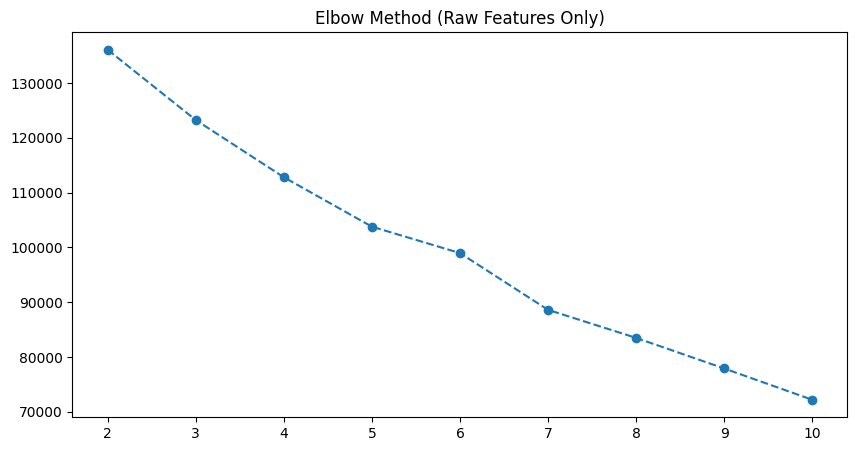

In [7]:
# 1. Load Data
df = pd.read_csv('chicago_airbnb_cleaned.csv')

# 2. Define Raw Strategic Features
# We remove PCA 1-5 and focus on capacity, price, and operational metrics
raw_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
    'host_is_superhost', 'host_listings_count', 'minimum_nights',
    'instant_bookable', 'availability_365', 'number_of_reviews',
    'reviews_per_month', 'review_scores_rating',
    'room_type_Private room', 'room_type_Shared room', 'room_type_Hotel room',
    'property_type_clean_Entire home', 'property_type_clean_Entire rental unit'
]

# Ensure numeric format and handle potential string errors (t/f or Hyde Park)
#
X = df[raw_features].copy()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].map({'t': 1, 'f': 0, 1: 1, 0: 0}).fillna(0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 3. Standardization & Clustering
X_scaled = StandardScaler().fit_transform(X)

# Re-run Elbow Method to see if the optimal K shifts without PCA noise
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method (Raw Features Only)')
plt.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


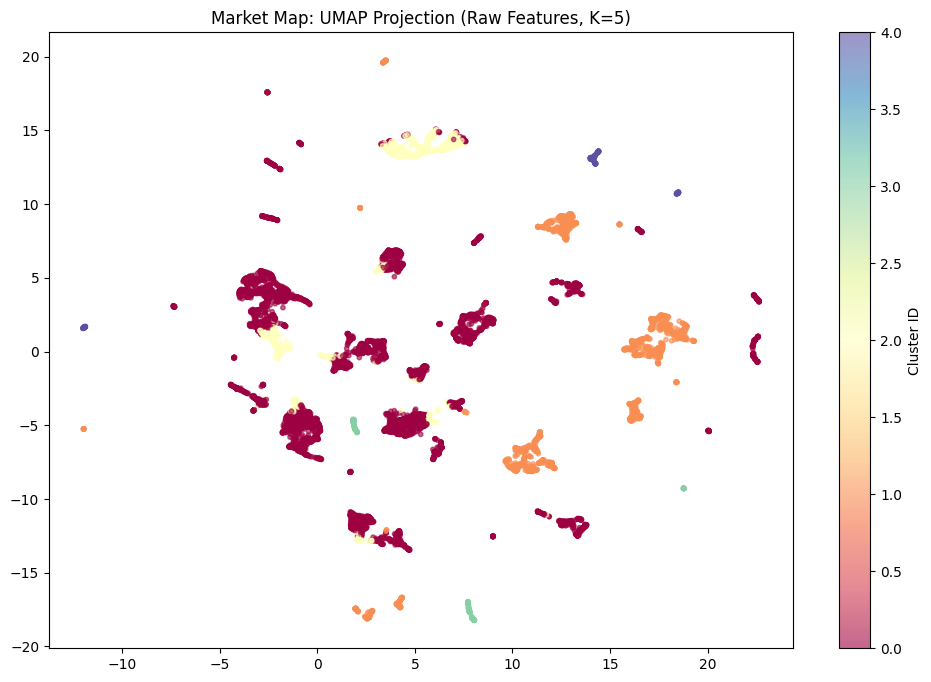

In [11]:
# 4. Final Clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_5'] = kmeans.fit_predict(X_scaled)

# 5. UMAP for Market Map Visualization
#
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Cluster_5'], cmap='Spectral', s=10, alpha=0.6)
plt.title(f'Market Map: UMAP Projection (Raw Features, K={optimal_k})')
plt.colorbar(label='Cluster ID')
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


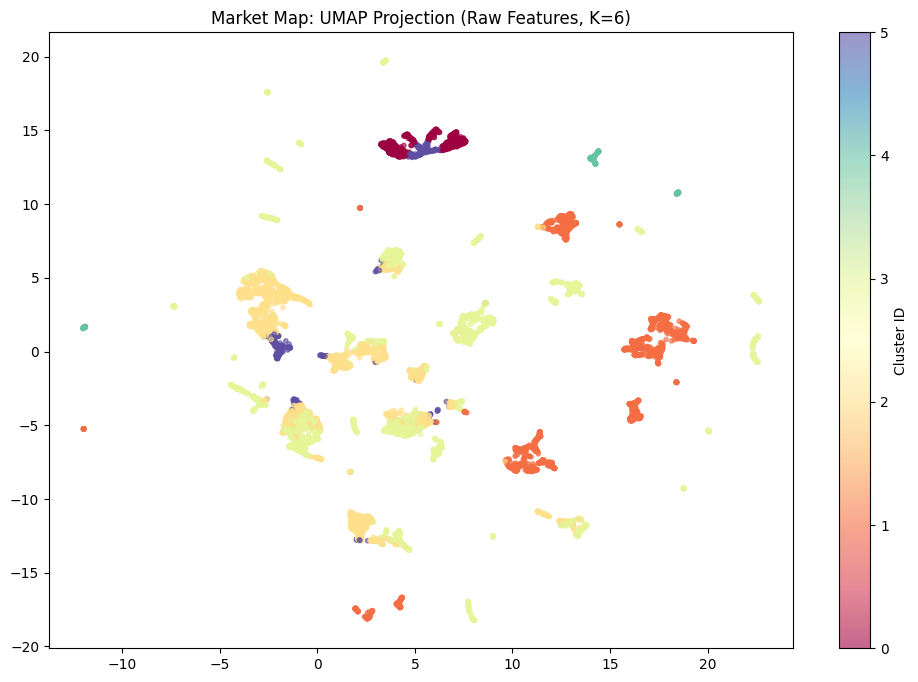

In [13]:
# 4. Final Clustering (K=6)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_6'] = kmeans.fit_predict(X_scaled)

# 5. UMAP for Market Map Visualization
#
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Cluster_6'], cmap='Spectral', s=10, alpha=0.6)
plt.title(f'Market Map: UMAP Projection (Raw Features, K={optimal_k})')
plt.colorbar(label='Cluster ID')
plt.show()

In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

raw_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
    'host_is_superhost', 'host_listings_count', 'minimum_nights',
    'instant_bookable', 'availability_365', 'number_of_reviews',
    'reviews_per_month', 'review_scores_rating'
]


X = df[raw_features].copy()

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].map({'t': 1, 'f': 0, 1: 1, 0: 0}).fillna(0)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

km5 = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster_5'] = km5.fit_predict(X_scaled)
km6 = KMeans(n_clusters=6, random_state=42, n_init=10)
df['Cluster_6'] = km6.fit_predict(X_scaled)

def get_metrics(X, labels):
    return {
        "Silhouette": round(silhouette_score(X, labels), 4),
        "DBI": round(davies_bouldin_score(X, labels), 4),
        "CHI": round(calinski_harabasz_score(X, labels), 4)
    }

print(f"K=5: {get_metrics(X_scaled, df['Cluster_5'])}")
print(f"K=6: {get_metrics(X_scaled, df['Cluster_6'])}")

profile_vars = ['price', 'accommodates', 'bedrooms', 'review_scores_rating', 'availability_365']

print("\n📈 K=5：")
print(df.groupby('Cluster_5')[profile_vars].mean().round(2).sort_values(by='price', ascending=False))

print("\n📈 K=6：")
print(df.groupby('Cluster_6')[profile_vars].mean().round(2).sort_values(by='price', ascending=False))

K=5: {'Silhouette': np.float64(0.1883), 'DBI': np.float64(1.3145), 'CHI': np.float64(1363.6979)}
K=6: {'Silhouette': np.float64(0.1803), 'DBI': np.float64(1.3053), 'CHI': np.float64(1328.3576)}

📈 K=5：
              price  accommodates  bedrooms  review_scores_rating  \
Cluster_5                                                           
4          45373.61          5.69      1.76                  4.62   
1            489.83         10.73      4.13                  4.82   
3            435.91          2.29      1.04                  4.84   
2            171.74          3.97      1.66                  4.88   
0            152.89          3.25      1.45                  4.70   

           availability_365  
Cluster_5                    
4                    306.43  
1                    254.67  
3                    361.17  
2                    223.33  
0                    222.31  

📈 K=6：
              price  accommodates  bedrooms  review_scores_rating  \
Cluster_6                  

In [14]:
master_df = df.copy()

cols_to_export = [
    'id', 'latitude', 'longitude', 'price', 'accommodates',
    'bedrooms', 'review_scores_rating', 'availability_365',
    'Cluster_5'
]

master_df.to_csv('chicago_airbnb_master_features.csv', index=False)

master_df[['id', 'Cluster_5']].to_csv('airbnb_cluster_labels.csv', index=False)